# **Chest X-Ray Classifier**

Standard protocol for patient arrivals in emergency departments exhibiting signs of cardiovascular, pulmonary, or respiratory complications includes the administration of [chest radiographs](https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/chest-xray#:~:text=A%20chest%20X%2Dray%20is,of%20the%20heart%20or%20lungs.), more commonly known as CXRs or chest X-rays. Both the [NIH](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9858224/#:~:text=Chest%20X%2Dray%20(CXR),performed%20at%20the%20patient's%20bed.) and the [NHS](https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2019/12/Provisional-Monthly-Diagnostic-Imaging-Dataset-Statistics-2019-12-19-1.pdf) report that chest radiographs consistently remain the most requested imaging tests and among the most requested examinations by emergency providers and general practitioners. This image classification model, trained on a [dataset](https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset) of [postoanterior (PA)](https://radiopaedia.org/articles/chest-pa-view-1?lang=us) chest radiographs, aims to aid in rapidly and accurately identifying the presence of [Pneumonia](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204) and [COVID-19](https://www.mayoclinic.org/diseases-conditions/coronavirus/symptoms-causes/syc-20479963) through medical imaging.






In [112]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pathlib
from PIL import Image

### Processing Data

In [115]:
input_folders = ['Images/covid', 'Images/normal', 'Images/pneumonia']
os.makedirs('ProcessedImages', exist_ok=True)
output_format='JPEG'
for folder in input_folders:
    folder_name = os.path.basename(folder)
    category_output_folder = os.path.join('ProcessedImages', folder_name)
    os.makedirs(category_output_folder, exist_ok=True)
    for filename in os.listdir(folder):
        input_path = os.path.join(folder, filename)
        if os.path.isfile(input_path) and any(filename.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif']):
            with Image.open(input_path) as img:
                output_path = os.path.join(category_output_folder, os.path.splitext(filename)[0] + f'.{output_format.lower()}')
                img.convert('RGB').save(output_path, format=output_format)

Ensures that every image in the data set is formatted to adhere to JPEG compression.

### Loading Data

In [7]:
data_dir = pathlib.Path('ProcessedImages').with_suffix('')

In [8]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

6868


### Splitting Data

In [10]:
batch_size = 128
img_height = 256
img_width = 256

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6868 files belonging to 3 classes.
Using 5495 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6868 files belonging to 3 classes.
Using 1373 files for validation.


Divides the images into 2 subsets:

Training set - used to train the model

Validation set - intermediary set used for fine-tuning the model and preventing overfitting; while training, it periodically helps assess how well the model generalizes to data it hasn't been trained on

### Visualizing Data

In [17]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Pneumonia']


Classes: Covid X-Rays, Normal X-Rays, Pneumonia X-Rays

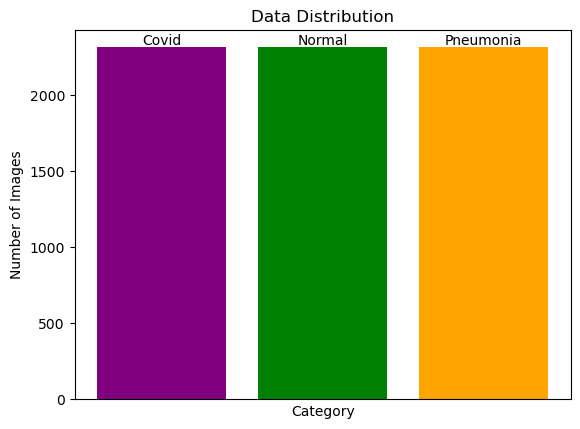

In [19]:
subdirectories = [os.path.join('Images', d) for d in os.listdir('Images') if os.path.isdir(os.path.join('Images', d))]
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))
container=plt.bar(subdirectories, counts, color=['purple', 'green', 'orange'])
plt.xticks([],rotation=90)
plt.ylabel("Number of Images")
plt.xlabel("Category")
plt.bar_label(container=container, labels=['Covid', 'Normal', 'Pneumonia'])
plt.title("Data Distribution")
plt.show()

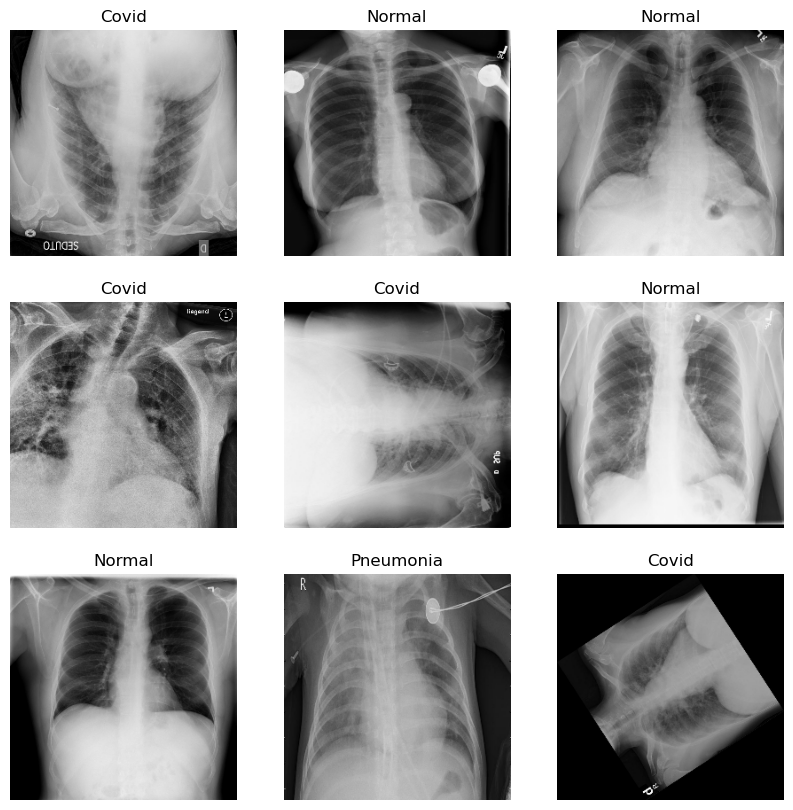

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Data Augmentation

Data augmentation will allow for artificially increasing the size/diversity of the training set by making small changes to the original images. This way, every epoch that the model trains for, it will be training on slightly modified images. For this model, Keras layers are added to randomly flip the images horizontally and vertically and to randomly rotate them up to 20 degrees.

In [23]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.2)
  ]
)

### Transfer Learning and Fine Tuning

Due to the relatively small size of the dataset, transfer learning and fine-tuning will be employed to increase the effectiveness of the model. Rather than training completely from scratch, this model will incorporate its upper layers from ResNet-50, a convolutional neural network that has already been trained on the massive [ImageNet database](https://www.image-net.org/) and is consequently extremely effective at image classification. The model will inherit these weights and continue the training process on its much smaller PA Chest X-Rays Dataset.

In [26]:
model=tf.keras.Sequential()
pretrained_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    classes=4,
    classifier_activation="softmax",
)

for layer in pretrained_model.layers:
    layer.trainable=False   

### Building Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import regularizers

In [29]:
model.add(data_augmentation)
model.add(pretrained_model)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

Dense Layers: regular neural network layer; 'dense' because each of its neurons are connected to every single neuron of the previous layer

Flatten Layers: convert multidimensional input into one-dimensional input

Dropout Layers: regularization technique used to prevent overfitting; randomly ignores or "drops out" a given percentage of layer outputs during training in order to prevent co-adaptation of neurons

Rectified Linear Unit (ReLU) Activation Function: piecewise linear function which directly outputs positive inputs and outputs zero for any non positive inputs( f(x) = max(0, x) ) 

Softmax Activation Function: logistic function generalized for multiple classes/dimenstions; assigns decimal probabilities to each class

In [35]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = 'adam', metrics=['accuracy'])

The Adam Optimizer, short for 'Adaptive Moment Estimation' is an iterative optimization algorithm which continously customizes the learning rate of each parameter based on its gradient history, allowing the algorithm to adapt as training progresses.

### Model Summary

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 8, 8, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 4)                

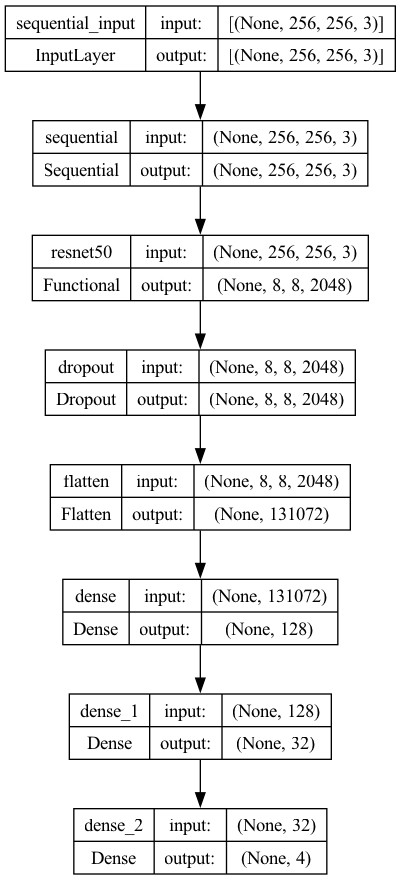

In [39]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

### Training Model

In [41]:
my_callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
num_epochs=20
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, callbacks=my_callbacks)

Epoch 1/20
43/43 [==============================] - 318s 7s/step - loss: 6.4694 - accuracy: 0.7146 - val_loss: 1.7526 - val_accuracy: 0.8172
Epoch 2/20
43/43 [==============================] - 336s 8s/step - loss: 0.7347 - accuracy: 0.8815 - val_loss: 0.6854 - val_accuracy: 0.9104
Epoch 3/20
43/43 [==============================] - 345s 8s/step - loss: 0.4426 - accuracy: 0.9103 - val_loss: 0.5926 - val_accuracy: 0.9126
Epoch 4/20
43/43 [==============================] - 302s 7s/step - loss: 0.4078 - accuracy: 0.9154 - val_loss: 0.4675 - val_accuracy: 0.9090
Epoch 5/20
43/43 [==============================] - 295s 7s/step - loss: 0.4236 - accuracy: 0.9099 - val_loss: 0.3673 - val_accuracy: 0.9068
Epoch 6/20
43/43 [==============================] - 753s 18s/step - loss: 0.3267 - accuracy: 0.9221 - val_loss: 0.4468 - val_accuracy: 0.9257
Epoch 7/20
43/43 [==============================] - 373s 9s/step - loss: 0.3348 - accuracy: 0.9263 - val_loss: 0.4266 - val_accuracy: 0.8966
Epoch 8/20
4

### Evaluating Model

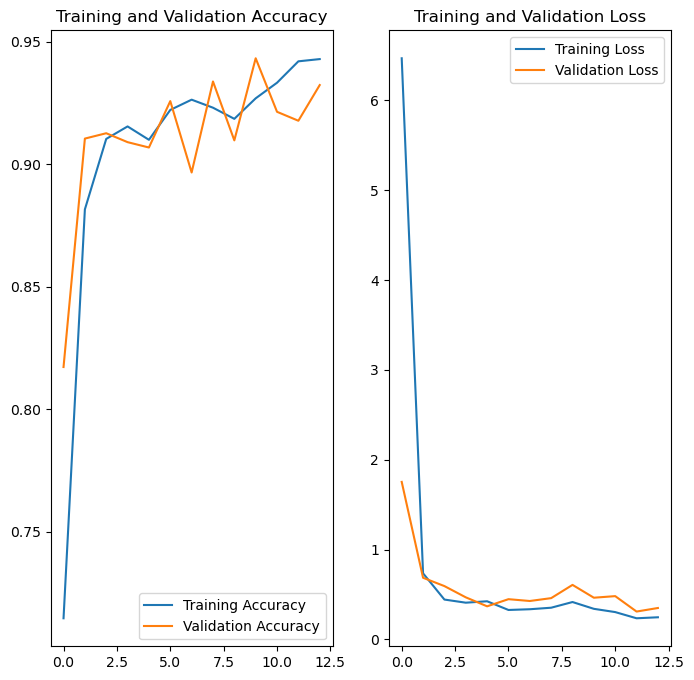

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The value of the loss function at a given epoch quantifies the difference between the predicted outputs of the algorithm and the actual target values; in other words, it is the penalty for a incorrect prediction magnified by how incorrect the prediction was.

Accuracy is a metric used to measure how often the model correctly predicts the outcome; Acc = # Correct Predictions / # Total Predictions.

The validation loss and validation accuracy values resulting from applying the model on the testing set indicate that the algorithm is reasonably effective at classifying postoanterior chest radiographs from the provided categories. 

### Testing Model

In [48]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [49]:
test_dir='TestImages'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=10,
  image_size=(img_height, img_width),
  batch_size=25
)

Found 786 files belonging to 3 classes.


In [50]:
y_pred = [] 
y_true = []  
for image_batch, label_batch in test_ds:      
   y_true.append(label_batch)   
   preds = model.predict(image_batch)  
   y_pred.append(np.argmax(preds, axis = - 1))
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 457ms/step


In [51]:
cm=confusion_matrix(y_true=correct_labels, y_pred=predicted_labels)

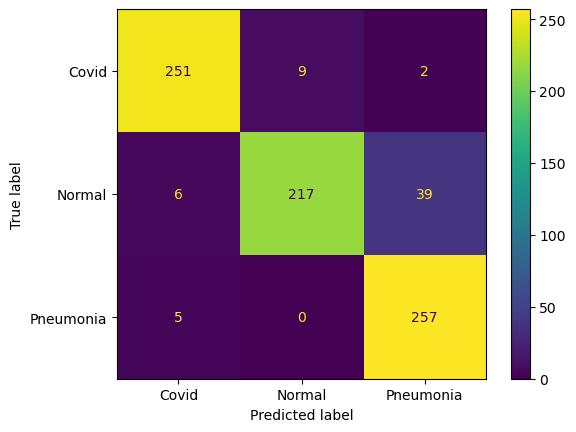

In [52]:
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

Confusion Matrix: also known as an error matrix, a matrix representation of model testing results allowing for the identification of classes that the algorithm is 'confusing' or misidentifying for another class(es). The confusion matrix here suggests that the algorithm is occasionally conflating Pneumonia X-rays with healthy X-rays.

In [54]:
cr=classification_report(correct_labels, predicted_labels, target_names=class_names)
print(cr)

              precision    recall  f1-score   support

       Covid       0.96      0.96      0.96       262
      Normal       0.96      0.83      0.89       262
   Pneumonia       0.86      0.98      0.92       262

    accuracy                           0.92       786
   macro avg       0.93      0.92      0.92       786
weighted avg       0.93      0.92      0.92       786



Precision: a metric which measures model performance in terms of quality; calculated as the ratio between the number of 'True Positives' and the sum of the number of 'True Positives' and the number of 'False Positives'; a high precision indicates that the model returns more relevant or 'precise' results than irrelevant ones.

Recall: a metric which measures model performance in terms of quantity; calculated as the ratio between the number of 'True Positives' and the sum of the number of 'True Positives' and the number of 'False Negatives'; a high recall indicates that the model returns most of the relevant results, regardless of how many irrelevant results are also returned.

F1-Score: measures predictive model performance by integrating precision and recall into a single metric; calculated as the harmonic mean of the precision and recall scores; ranges from 0 to 1, with 0 indicating poor performance and 1 indicating perfect performance.

Given the high F1-scores for each category and a high test accuracy of 92%, along with measures in place to safeguard against overfitting, it can be concluded that the model is effective at classifying posteroanterior chest radiographs, with a small margin for improvement. 